<a href="https://colab.research.google.com/github/n2van/Spam-SMS-Classification/blob/main/Spam_SMS_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data and import library

## Pip library (because in google colab haven't this library)

In [1]:
!pip install tensorflow
!pip install nltk

# Import library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

## Load data and analysis

In [3]:
df = pd.read_csv('/content/sample_data/Data/Spam_SMS.csv')
df_coppy = df
df.sample(10)

,Class,Message
4717,ham,Hey. What happened? U switch off ur cell d who...
5433,ham,If I was I wasn't paying attention
431,ham,At home watching tv lor.
518,spam,Your credits have been topped up for http://ww...
1520,ham,Check wid corect speling i.e. Sarcasm
2513,ham,"Hiya , have u been paying money into my accoun..."
2934,ham,Yo do you know anyone &lt;#&gt; or otherwise...
4988,ham,No rushing. I'm not working. I'm in school so ...
743,ham,Just got up. have to be out of the room very s...
4074,ham,Was the actual exam harder than NBME


In [4]:
df.duplicated().sum()

415

In [5]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5159 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5159 non-null   object
 1   Message  5159 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


In [6]:
df["Class"].value_counts()

,count
Class,
ham,4518
spam,641


In [7]:
class_encoder = LabelEncoder()
class_encoder.fit(df["Class"])
df["Class_code"] = class_encoder.transform(df["Class"])

labels = class_encoder.classes_.tolist()
print(labels)

['ham', 'spam']


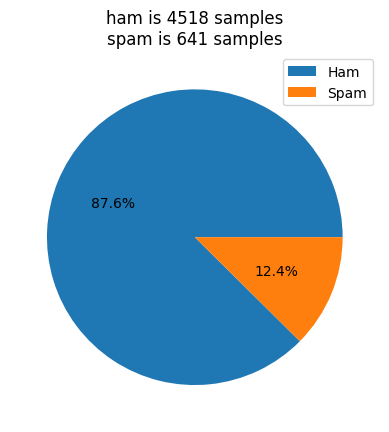

In [8]:
fig, ax =  plt.subplots()
ax.pie(df.Class.value_counts().values, autopct = '%.1f%%')
ax.legend(["Ham","Spam"])
plt.title(f"{df.Class.value_counts().index[0]} is {df.Class.value_counts().values[0]} samples\n{df.Class.value_counts().index[1]} is {df.Class.value_counts().values[1]} samples")
fig.show()

# Data preprocessing

In [9]:
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
stop_words = list(set(sw))
def remove_stopwords(text):
    text = ' '.join([word for word in text.lower().split() if word not in stop_words])
    return text

In [11]:
df['Message_Trim'] = [remove_stopwords(Text) for Text in df['Message']]

In [12]:
def form_worldcloud_string(df, column):
    string = " ".join(df[column].values.tolist())
    words = [text.capitalize() for text in string.split() if len(text) > 2]
    string = " ".join(words)
    return string

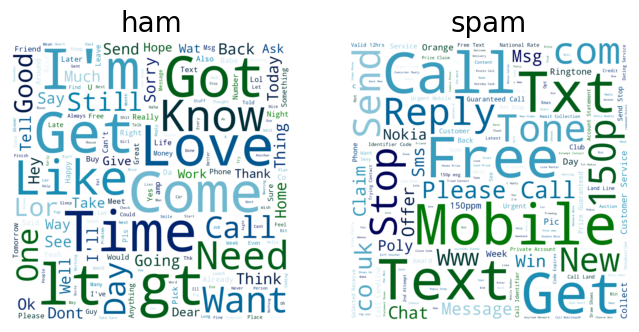

In [13]:
n_col = int(np.ceil(np.sqrt(len(labels))))
n_row = int(np.ceil(len(labels) / n_col))

fig, axes = plt.subplots(n_row, n_col, figsize=(4 * n_col, 4 * n_row))

for ax in axes.flatten():
    ax.axis("off")

for i, (ax, label) in enumerate(zip(axes.flatten(), labels)):
    str_return =form_worldcloud_string(
        df.loc[df["Class"] == label, :],
        "Message_Trim",
    )

    # Generate a WordCloud image
    wc = WordCloud(
        width=1000,
        height=1000,
        colormap="ocean",
        background_color="white",
        min_font_size=10,
        max_font_size=200,
        max_words=200,
        stopwords=stop_words,
        relative_scaling=0,
        random_state=42,
        margin=20,
    )
    wc.generate(str_return)

    # Show WordCloud image
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(label, fontsize=20, color="black")

plt.show()

Words such as 'Free', 'Text', 'Call', 'Now', and 'Reply' appear more frequently in spam messages compared to legitimate messages.



# Modeling and evaluating


In [14]:
tokenizer = Tokenizer(oov_token='<00U00>')

In [15]:
tokenizer.fit_on_texts(df['Message_Trim'])
sequneces = tokenizer.texts_to_sequences(df['Message_Trim'])
matrix = pad_sequences(sequneces,
                       padding='post',
                       truncating='post',
                       maxlen=16)

In [16]:
class_dict = {'ham':0,'spam':1}
encoded_label = np.array([class_dict[i] for i in df.Class],dtype='int32')

In [17]:
model = Sequential([Embedding(len(tokenizer.word_index)+1,2),
                    GlobalMaxPooling1D(),
                    Dense(128, activation="relu"),
                    Dropout(0.5),
                    Dense(64, activation="relu"),
                    Dropout(0.5),
                    Dense(32, activation="relu"),
                    Dense(1,activation='sigmoid')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(matrix, encoded_label, test_size=0.25, random_state=64,shuffle = True)

In [20]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    epochs=64, batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8671 - loss: 0.5617 - val_accuracy: 0.8814 - val_loss: 0.2931 - learning_rate: 0.0010
Epoch 2/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8687 - loss: 0.3066 - val_accuracy: 0.8814 - val_loss: 0.2543 - learning_rate: 0.0010
Epoch 3/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8684 - loss: 0.2527 - val_accuracy: 0.8814 - val_loss: 0.2348 - learning_rate: 0.0010
Epoch 4/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8855 - loss: 0.2318 - val_accuracy: 0.9481 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 5/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9588 - loss: 0.1953 - val_accuracy: 0.9465 - val_loss: 0.1877 - learning_rate: 0.0010
Epoch 6/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9621 - loss: 0.1508 - val_accuracy: 0.9488 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 7/64
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9606 - loss: 0.1248 - val_accuracy

<Axes: >

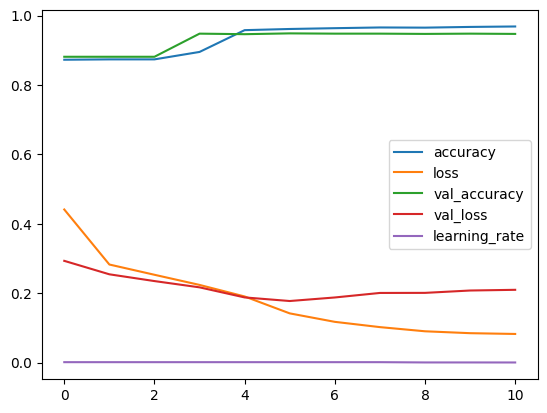

In [21]:
df2=pd.DataFrame(model.history.history)
df2.plot()

In [22]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Confusion Matrix = 
 [[1120   17]
 [  49  104]] 



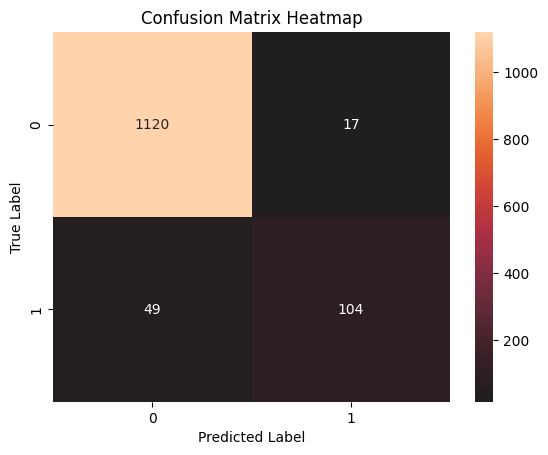

In [23]:
CM=confusion_matrix(y_test,y_pred)

print("Confusion Matrix = \n", CM, "\n")


sns.heatmap(CM, annot=True, fmt='d', center=0, cbar=True)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')


plt.show()